In [9]:
# Project Setup and Imports
"""
===========================================
SPARKSCALE CHURN - TELECOM PREDICTION PROJECT
===========================================
Complete Production Pipeline Implementation 
"""

print("="*70)
print("SPARKSCALE CHURN PREDICTION - PRODUCTION PIPELINE")
print("="*70)
print("\nProject Overview:")
print("•  1: ETL & Data Storage")
print("•  2: Feature Engineering")
print("•  3: Machine Learning with scikit-learn")
print("•  4: Model Persistence & Deployment")
print("\n" + "="*70)

# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
import os
import time
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
import joblib

print("✓ All libraries imported successfully")
print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Note: Running in pandas mode ")

SPARKSCALE CHURN PREDICTION - PRODUCTION PIPELINE

Project Overview:
•  1: ETL & Data Storage
•  2: Feature Engineering
•  3: Machine Learning with scikit-learn
•  4: Model Persistence & Deployment

✓ All libraries imported successfully
Current time: 2025-12-24 20:36:42
Note: Running in pandas mode 


In [ ]:
# Generate Telecom Dataset (Simplified Working Version)
"""
===========================================
DATASET GENERATION - TELECOM LOGS
===========================================
Generate realistic telecom customer data
"""

print("Generating telecom customer dataset...")
print("-" * 50)

def generate_telecom_data(num_customers=10000, days_history=30):
    """
    Generate telecom data for churn prediction
    - num_customers: Number of unique customers
    - days_history: Historical days of data
    """
    
    print(f"Creating dataset for {num_customers:,} customers over {days_history} days...")
    start_time = time.time()
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # 1. Generate Customer Base
    print("Step 1: Creating customer base...")
    customer_ids = [f'TEL{str(i).zfill(8)}' for i in range(num_customers)]
    
    customer_data = []
    for i, cust_id in enumerate(customer_ids):
        # Generate realistic customer profiles
        tenure = np.random.randint(1, 72)  # Months (up to 6 years)
        age = np.random.randint(18, 80)
        income_tier = np.random.choice(['Low', 'Medium', 'High'], p=[0.3, 0.5, 0.2])
        contract_type = np.random.choice(['Month-to-Month', 'One Year', 'Two Year'], 
                                        p=[0.5, 0.3, 0.2])
        plan_type = np.random.choice(['Basic', 'Standard', 'Premium'], 
                                    p=[0.4, 0.4, 0.2])
        region = np.random.choice(['North', 'South', 'East', 'West'])
        
        customer_data.append({
            'customer_id': cust_id,
            'tenure_months': tenure,
            'age': age,
            'income_tier': income_tier,
            'contract_type': contract_type,
            'plan_type': plan_type,
            'region': region,
            'senior_citizen': 1 if age >= 65 else 0,
            'has_partner': np.random.choice([0, 1], p=[0.45, 0.55]),
            'has_dependents': np.random.choice([0, 1], p=[0.6, 0.4]),
            'signup_date': (datetime.now() - timedelta(days=np.random.randint(30, 2190))).strftime('%Y-%m-%d')
        })
    
    customers_df = pd.DataFrame(customer_data)
    
    # 2. Generate Daily Activity Logs
    print("Step 2: Generating daily activity logs...")
    
    all_logs = []
    current_date = datetime.now()
    
    # Generate logs for each day
    for day_offset in range(days_history):
        log_date = current_date - timedelta(days=day_offset)
        date_str = log_date.strftime('%Y-%m-%d')
        
        # Each day, 70% of customers are active
        active_customers = np.random.choice(customer_ids, 
                                          size=int(num_customers * 0.7), 
                                          replace=False)
        
        for cust_id in active_customers:
            # Get customer profile for realistic behavior
            cust_profile = customers_df[customers_df['customer_id'] == cust_id].iloc[0]
            
            # Base usage based on plan type
            if cust_profile['plan_type'] == 'Premium':
                call_base, data_base, bill_base = 300, 10, 120
            elif cust_profile['plan_type'] == 'Standard':
                call_base, data_base, bill_base = 180, 5, 80
            else:  # Basic
                call_base, data_base, bill_base = 100, 2, 50
            
            # Generate daily metrics with some randomness
            call_duration = max(0, np.random.normal(call_base, call_base/3))
            data_usage = max(0, np.random.gamma(shape=2, scale=data_base/2))
            bill_amount = max(20, np.random.normal(bill_base, bill_base/4))
            
            # Special events (complaints, service calls)
            complaint_flag = np.random.choice([0, 1], p=[0.98, 0.02])
            service_calls = np.random.poisson(0.2)
            payment_delay = np.random.poisson(2)
            
            # Roaming and international usage
            roaming_flag = np.random.choice([0, 1], p=[0.9, 0.1])
            international_minutes = np.random.exponential(10)
            
            all_logs.append({
                'customer_id': cust_id,
                'log_date': date_str,
                'call_duration_min': round(call_duration, 2),
                'data_usage_gb': round(data_usage, 2),
                'bill_amount': round(bill_amount, 2),
                'complaint_flag': complaint_flag,
                'customer_service_calls': service_calls,
                'payment_delay_days': payment_delay,
                'roaming_flag': roaming_flag,
                'international_minutes': round(international_minutes, 2),
                'call_drop_rate': round(np.random.uniform(0, 0.1), 3),
                'network_quality': round(np.random.uniform(3.0, 5.0), 1)
            })
        
        if (day_offset + 1) % 10 == 0:
            print(f"  Processed {day_offset + 1}/{days_history} days...")
    
    logs_df = pd.DataFrame(all_logs)
    
    # 3. Calculate Churn Labels (Business Logic)
    print("Step 3: Calculating churn labels...")
    
    # Aggregate logs to calculate features for churn prediction
    agg_features = logs_df.groupby('customer_id').agg({
        'call_duration_min': ['mean', 'std'],
        'data_usage_gb': ['mean', 'std'],
        'bill_amount': ['mean', 'sum'],
        'complaint_flag': 'sum',
        'customer_service_calls': 'sum',
        'payment_delay_days': 'mean',
        'roaming_flag': 'sum',
        'international_minutes': 'sum',
        'call_drop_rate': 'mean'
    }).reset_index()
    
    agg_features.columns = ['_'.join(col).strip('_') for col in agg_features.columns.values]
    agg_features = agg_features.rename(columns={'customer_id_': 'customer_id'})
    
    # Merge with customer data
    full_data = pd.merge(customers_df, agg_features, on='customer_id', how='left')
    
    # Fill NaN values
    numeric_cols = full_data.select_dtypes(include=[np.number]).columns
    full_data[numeric_cols] = full_data[numeric_cols].fillna(0)
    
    # Churn prediction rules (business logic)
    def calculate_churn_probability(row):
        probability = 0.0
        
        # High complaints increase churn probability
        if row['complaint_flag_sum'] > 3:
            probability += 0.4
        elif row['complaint_flag_sum'] > 0:
            probability += 0.2
        
        # Payment delays
        if row['payment_delay_days_mean'] > 5:
            probability += 0.3
        elif row['payment_delay_days_mean'] > 2:
            probability += 0.15
        
        # Low usage
        if row['data_usage_gb_mean'] < 1.0:
            probability += 0.2
        
        # Contract type
        if row['contract_type'] == 'Month-to-Month':
            probability += 0.25
        elif row['contract_type'] == 'One Year':
            probability += 0.1
        
        # Recent service calls
        if row['customer_service_calls_sum'] > 5:
            probability += 0.3
        
        # Short tenure
        if row['tenure_months'] < 6:
            probability += 0.15
        
        return min(probability, 0.95)
    
    full_data['churn_probability'] = full_data.apply(calculate_churn_probability, axis=1)
    
    # Convert to binary label (target churn rate ~25%)
    threshold = np.percentile(full_data['churn_probability'], 75)
    full_data['churn_label'] = (full_data['churn_probability'] > threshold).astype(int)
    
    # 4. Save datasets
    print("Step 4: Saving datasets...")
    
    os.makedirs('telecom_data', exist_ok=True)
    os.makedirs('telecom_data/logs', exist_ok=True)
    os.makedirs('telecom_data/customers', exist_ok=True)
    
    # Save in chunks for distributed processing simulation
    chunk_size = 10000
    for i in range(0, len(logs_df), chunk_size):
        chunk = logs_df.iloc[i:i+chunk_size]
        chunk.to_csv(f'telecom_data/logs/logs_chunk_{i//chunk_size}.csv', index=False)
    
    # Save customer features
    full_data.to_csv('telecom_data/customer_features.csv', index=False)
    
    elapsed_time = time.time() - start_time
    
    # 5. Dataset Statistics
    print("\n" + "="*50)
    print("DATASET GENERATION COMPLETE")
    print("="*50)
    print(f"Generation time: {elapsed_time:.2f} seconds")
    print(f"\nDataset Statistics:")
    print(f"• Total customers: {len(full_data):,}")
    print(f"• Total log records: {len(logs_df):,}")
    print(f"• Daily log records: {len(logs_df)/days_history:,.0f}")
    print(f"• Churn rate: {full_data['churn_label'].mean():.2%}")
    print(f"\nFiles saved in 'telecom_data/' directory:")
    print(f"• Log files: {len(logs_df)//chunk_size + 1} chunks")
    print(f"• Customer features: 1 file")
    print("="*50)
    
    return full_data, logs_df

# Generate dataset with smaller size for testing first
print("Starting dataset generation...")
try:
    customers_df, logs_df = generate_telecom_data(num_customers=10000, days_history=30)
    print("\n✅ Dataset generation successful!")
    print(f"\nSample customer data:")
    print(customers_df[['customer_id', 'tenure_months', 'contract_type', 'churn_label']].head())
    print(f"\nSample log data:")
    print(logs_df.head())
except Exception as e:
    print(f"❌ Error during dataset generation: {str(e)}")
    import traceback
    traceback.print_exc()

Generating telecom customer dataset...
--------------------------------------------------
Starting dataset generation...
Creating dataset for 10,000 customers over 30 days...
Step 1: Creating customer base...
Step 2: Generating daily activity logs...
  Processed 10/30 days...
  Processed 20/30 days...
  Processed 30/30 days...
Step 3: Calculating churn labels...
Step 4: Saving datasets...

DATASET GENERATION COMPLETE
Generation time: 348.11 seconds

Dataset Statistics:
• Total customers: 10,000
• Total log records: 210,000
• Daily log records: 7,000
• Churn rate: 19.19%

Files saved in 'telecom_data/' directory:
• Log files: 22 chunks
• Customer features: 1 file

✅ Dataset generation successful!

Sample customer data:
   customer_id  tenure_months   contract_type  churn_label
0  TEL00000000             52        One Year            0
1  TEL00000001             24        Two Year            0
2  TEL00000002             58  Month-to-Month            0
3  TEL00000003             15       

In [ ]:
# Data Processing and Validation
"""
===========================================
 DATA PROCESSING & VALIDATION
===========================================
Load, validate, and prepare the telecom dataset
"""

print("Running data processing and validation...")
print("-" * 50)

import pandas as pd
import numpy as np
import glob

# Load datasets
print("Step 1: Loading telecom datasets...")

# Load all log files
log_files = glob.glob("telecom_data/logs/*.csv")
logs_df_list = []

if log_files:
    for file in log_files:
        try:
            df = pd.read_csv(file)
            logs_df_list.append(df)
            print(f"  Loaded {len(df)} records from {file}")
        except Exception as e:
            print(f"  Error loading {file}: {str(e)}")
    
    if logs_df_list:
        logs_combined = pd.concat(logs_df_list, ignore_index=True)
    else:
        print("  No log files found. Using generated logs_df...")
        logs_combined = logs_df
else:
    print("  No log files found. Using generated logs_df...")
    logs_combined = logs_df

# Load customer features
try:
    customer_features = pd.read_csv("telecom_data/customer_features.csv")
    print(f"  Loaded customer features: {len(customer_features)} records")
except:
    print("  Customer features file not found. Using generated customers_df...")
    customer_features = customers_df

# Week 1 Requirements: Data validation
print("\nStep 2: Data validation...")

# 1. Row counts
print(f"\n1. Row Counts:")
print(f"   • Log records: {len(logs_combined):,}")
print(f"   • Customer records: {len(customer_features):,}")

# 2. Schema validation
print(f"\n2. Schema Validation:")
print("   Logs Schema:")
print(logs_combined.dtypes.to_string())
print("\n   Customer Features Schema:")
print(customer_features.dtypes.to_string())

# 3. Data quality checks
print(f"\n3. Data Quality Checks:")
print("   Null values in Logs:")
print(logs_combined.isnull().sum().to_string())
print("\n   Null values in Customer Features:")
print(customer_features.isnull().sum().to_string())

# 4. Basic statistics
print(f"\n4. Basic Statistics:")
print("   Log Statistics:")
print(logs_combined[['call_duration_min', 'data_usage_gb', 'bill_amount']].describe().round(2))
print("\n   Customer Statistics:")
print(customer_features[['tenure_months', 'age', 'churn_probability']].describe().round(2))

# 5. Churn distribution
print(f"\n5. Churn Distribution:")
churn_counts = customer_features['churn_label'].value_counts()
churn_percentage = churn_counts / len(customer_features) * 100
for label, count in churn_counts.items():
    print(f"   Churn {label}: {count:,} ({churn_percentage[label]:.1f}%)")

# 6. Save processed data
print("\nStep 3: Saving processed data...")
customer_features.to_csv('telecom_data/processed_customer_features.csv', index=False)
logs_combined.to_csv('telecom_data/processed_logs.csv', index=False)

print("\n✓ Week 1: Data Processing Complete")
print("   - Datasets loaded and validated")
print("   - Schema checked for consistency")
print("   - Data quality metrics calculated")
print("   - Processed data saved for next steps")

Running data processing and validation...
--------------------------------------------------
Step 1: Loading telecom datasets...
  Loaded 10000 records from telecom_data/logs\logs_chunk_0.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_1.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_10.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_11.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_12.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_13.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_14.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_15.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_16.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_17.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_18.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_19.csv
  Loaded 10000 records from telecom_data/logs\logs_chunk_2.csv
  Loaded 10000 records from telecom_data/l

In [ ]:
#  Feature Engineering
"""
===========================================
 FEATURE ENGINEERING
===========================================
Create advanced features for churn prediction
"""

print("Running feature engineering...")
print("-" * 50)

# Load processed data
customer_features = pd.read_csv('telecom_data/processed_customer_features.csv')
logs_df = pd.read_csv('telecom_data/processed_logs.csv')

print(f"Loaded {len(customer_features)} customers and {len(logs_df)} log records")

# 1. Create time-based features from logs
print("\nStep 1: Creating time-based features...")

# Convert log_date to datetime
logs_df['log_date'] = pd.to_datetime(logs_df['log_date'])

# Calculate recency (days since last activity)
latest_date = logs_df['log_date'].max()
last_activity = logs_df.groupby('customer_id')['log_date'].max().reset_index()
last_activity['days_since_last_activity'] = (latest_date - last_activity['log_date']).dt.days

# Calculate frequency (number of active days)
activity_frequency = logs_df.groupby('customer_id')['log_date'].nunique().reset_index()
activity_frequency = activity_frequency.rename(columns={'log_date': 'active_days'})

# Calculate monetary value (total spend)
monetary_value = logs_df.groupby('customer_id')['bill_amount'].sum().reset_index()
monetary_value = monetary_value.rename(columns={'bill_amount': 'total_spend'})

# Merge RFM features
rfm_features = pd.merge(last_activity[['customer_id', 'days_since_last_activity']], 
                       activity_frequency, on='customer_id')
rfm_features = pd.merge(rfm_features, monetary_value, on='customer_id')

# 2. Create usage pattern features
print("Step 2: Creating usage pattern features...")

# Usage variability
usage_variability = logs_df.groupby('customer_id').agg({
    'call_duration_min': ['std', 'mean'],
    'data_usage_gb': ['std', 'mean'],
    'bill_amount': ['std', 'mean']
}).reset_index()

# Flatten column names
usage_variability.columns = ['customer_id', 
                            'call_std', 'call_mean',
                            'data_std', 'data_mean',
                            'bill_std', 'bill_mean']

# Calculate coefficient of variation
usage_variability['call_cv'] = usage_variability['call_std'] / usage_variability['call_mean']
usage_variability['data_cv'] = usage_variability['data_std'] / usage_variability['data_mean']
usage_variability['bill_cv'] = usage_variability['bill_std'] / usage_variability['bill_mean']

# 3. Create interaction features
print("Step 3: Creating interaction features...")

# Merge all features
all_features = pd.merge(customer_features, rfm_features, on='customer_id', how='left')
all_features = pd.merge(all_features, usage_variability, on='customer_id', how='left')

# Fill NaN values
all_features = all_features.fillna(0)

# Create interaction features
all_features['tenure_to_age_ratio'] = all_features['tenure_months'] / all_features['age']
all_features['spend_per_active_day'] = all_features['total_spend'] / all_features['active_days']
all_features['spend_per_active_day'] = all_features['spend_per_active_day'].replace([np.inf, -np.inf], 0)
all_features['spend_per_active_day'] = all_features['spend_per_active_day'].fillna(0)

# 4. Encode categorical variables
print("Step 4: Encoding categorical variables...")

# One-hot encode categorical features
categorical_cols = ['income_tier', 'contract_type', 'plan_type', 'region']
all_features_encoded = pd.get_dummies(all_features, columns=categorical_cols, drop_first=True)

# 5. Save engineered features
print("Step 5: Saving engineered features...")

# Select final feature columns (excluding identifiers and target)
feature_cols = [col for col in all_features_encoded.columns 
                if col not in ['customer_id', 'signup_date', 'churn_label', 'churn_probability']]

final_features = all_features_encoded[['customer_id', 'churn_label'] + feature_cols]
final_features.to_csv('telecom_data/engineered_features.csv', index=False)

print(f"\n✓ Feature Engineering Complete")
print(f"   • Total features created: {len(feature_cols)}")
print(f"   • Final dataset shape: {final_features.shape}")
print(f"   • Features saved to: telecom_data/engineered_features.csv")

# Display sample of engineered features
print("\nSample of engineered features:")
print(final_features.iloc[:3, :8])

Running feature engineering...
--------------------------------------------------
Loaded 10000 customers and 210000 log records

Step 1: Creating time-based features...
Step 2: Creating usage pattern features...
Step 3: Creating interaction features...
Step 4: Encoding categorical variables...
Step 5: Saving engineered features...

✓ Feature Engineering Complete
   • Total features created: 40
   • Final dataset shape: (10000, 42)
   • Features saved to: telecom_data/engineered_features.csv

Sample of engineered features:
   customer_id  churn_label  tenure_months  age  senior_citizen  has_partner  \
0  TEL00000000            0             52   46               0            0   
1  TEL00000001            0             24   20               0            0   
2  TEL00000002            0             58   39               0            0   

   has_dependents  call_duration_min_mean  
0               0                 182.896  
1               1                 309.797  
2               0  

In [5]:
# Cell 5: Machine Learning Model Training
"""
===========================================
WEEK 3: MACHINE LEARNING
===========================================
Train and evaluate churn prediction models
"""

print("Training machine learning models...")
print("-" * 50)

# Load engineered features
data = pd.read_csv('telecom_data/engineered_features.csv')

# Separate features and target
X = data.drop(['customer_id', 'churn_label'], axis=1)
y = data['churn_label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# 1. Scale features
print("\nStep 1: Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train multiple models
print("\nStep 2: Training models...")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

results = {}

for name, model in models.items():
    print(f"  Training {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = model.score(X_test_scaled, y_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"    Accuracy: {accuracy:.4f}")
    print(f"    ROC-AUC: {roc_auc:.4f}")

# 3. Hyperparameter tuning for best model
print("\nStep 3: Hyperparameter tuning for Random Forest...")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create and fit grid search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
y_pred_proba_best = best_rf.predict_proba(X_test_scaled)[:, 1]

best_accuracy = best_rf.score(X_test_scaled, y_test)
best_roc_auc = roc_auc_score(y_test, y_pred_proba_best)

print(f"  Best parameters: {grid_search.best_params_}")
print(f"  Best accuracy: {best_accuracy:.4f}")
print(f"  Best ROC-AUC: {best_roc_auc:.4f}")

# 4. Feature importance analysis
print("\nStep 4: Analyzing feature importance...")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# 5. Save models and results
print("\nStep 5: Saving models and results...")

# Save the best model
joblib.dump(best_rf, 'telecom_data/best_churn_model.pkl')
joblib.dump(scaler, 'telecom_data/scaler.pkl')

# Save feature importance
feature_importance.to_csv('telecom_data/feature_importance.csv', index=False)

# Save results summary
results_summary = pd.DataFrame({
    'Model': list(results.keys()) + ['Random Forest (Tuned)'],
    'Accuracy': [r['accuracy'] for r in results.values()] + [best_accuracy],
    'ROC-AUC': [r['roc_auc'] for r in results.values()] + [best_roc_auc]
})
results_summary.to_csv('telecom_data/model_results.csv', index=False)

print("\n✓ Machine Learning Complete")
print("   - Multiple models trained and evaluated")
print("   - Hyperparameter tuning performed")
print("   - Feature importance analyzed")
print("   - Models and results saved to disk")

Training machine learning models...
--------------------------------------------------
Training set: 7000 samples
Test set: 3000 samples
Number of features: 40

Step 1: Scaling features...

Step 2: Training models...
  Training Logistic Regression...
    Accuracy: 0.8910
    ROC-AUC: 0.9390
  Training Random Forest...
    Accuracy: 0.9923
    ROC-AUC: 0.9999
  Training Gradient Boosting...
    Accuracy: 0.9990
    ROC-AUC: 0.9990

Step 3: Hyperparameter tuning for Random Forest...
  Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
  Best accuracy: 0.9910
  Best ROC-AUC: 0.9999

Step 4: Analyzing feature importance...

Top 10 most important features:
  complaint_flag_sum: 0.2336
  customer_service_calls_sum: 0.2329
  payment_delay_days_mean: 0.1393
  contract_type_One Year: 0.0678
  contract_type_Two Year: 0.0661
  tenure_months: 0.0237
  tenure_to_age_ratio: 0.0235
  international_minutes_sum: 0.0121
  bill_cv: 0.0118
  call_drop_rate_mean: 0.0113

Ste

Creating visualizations and presenting results...
--------------------------------------------------


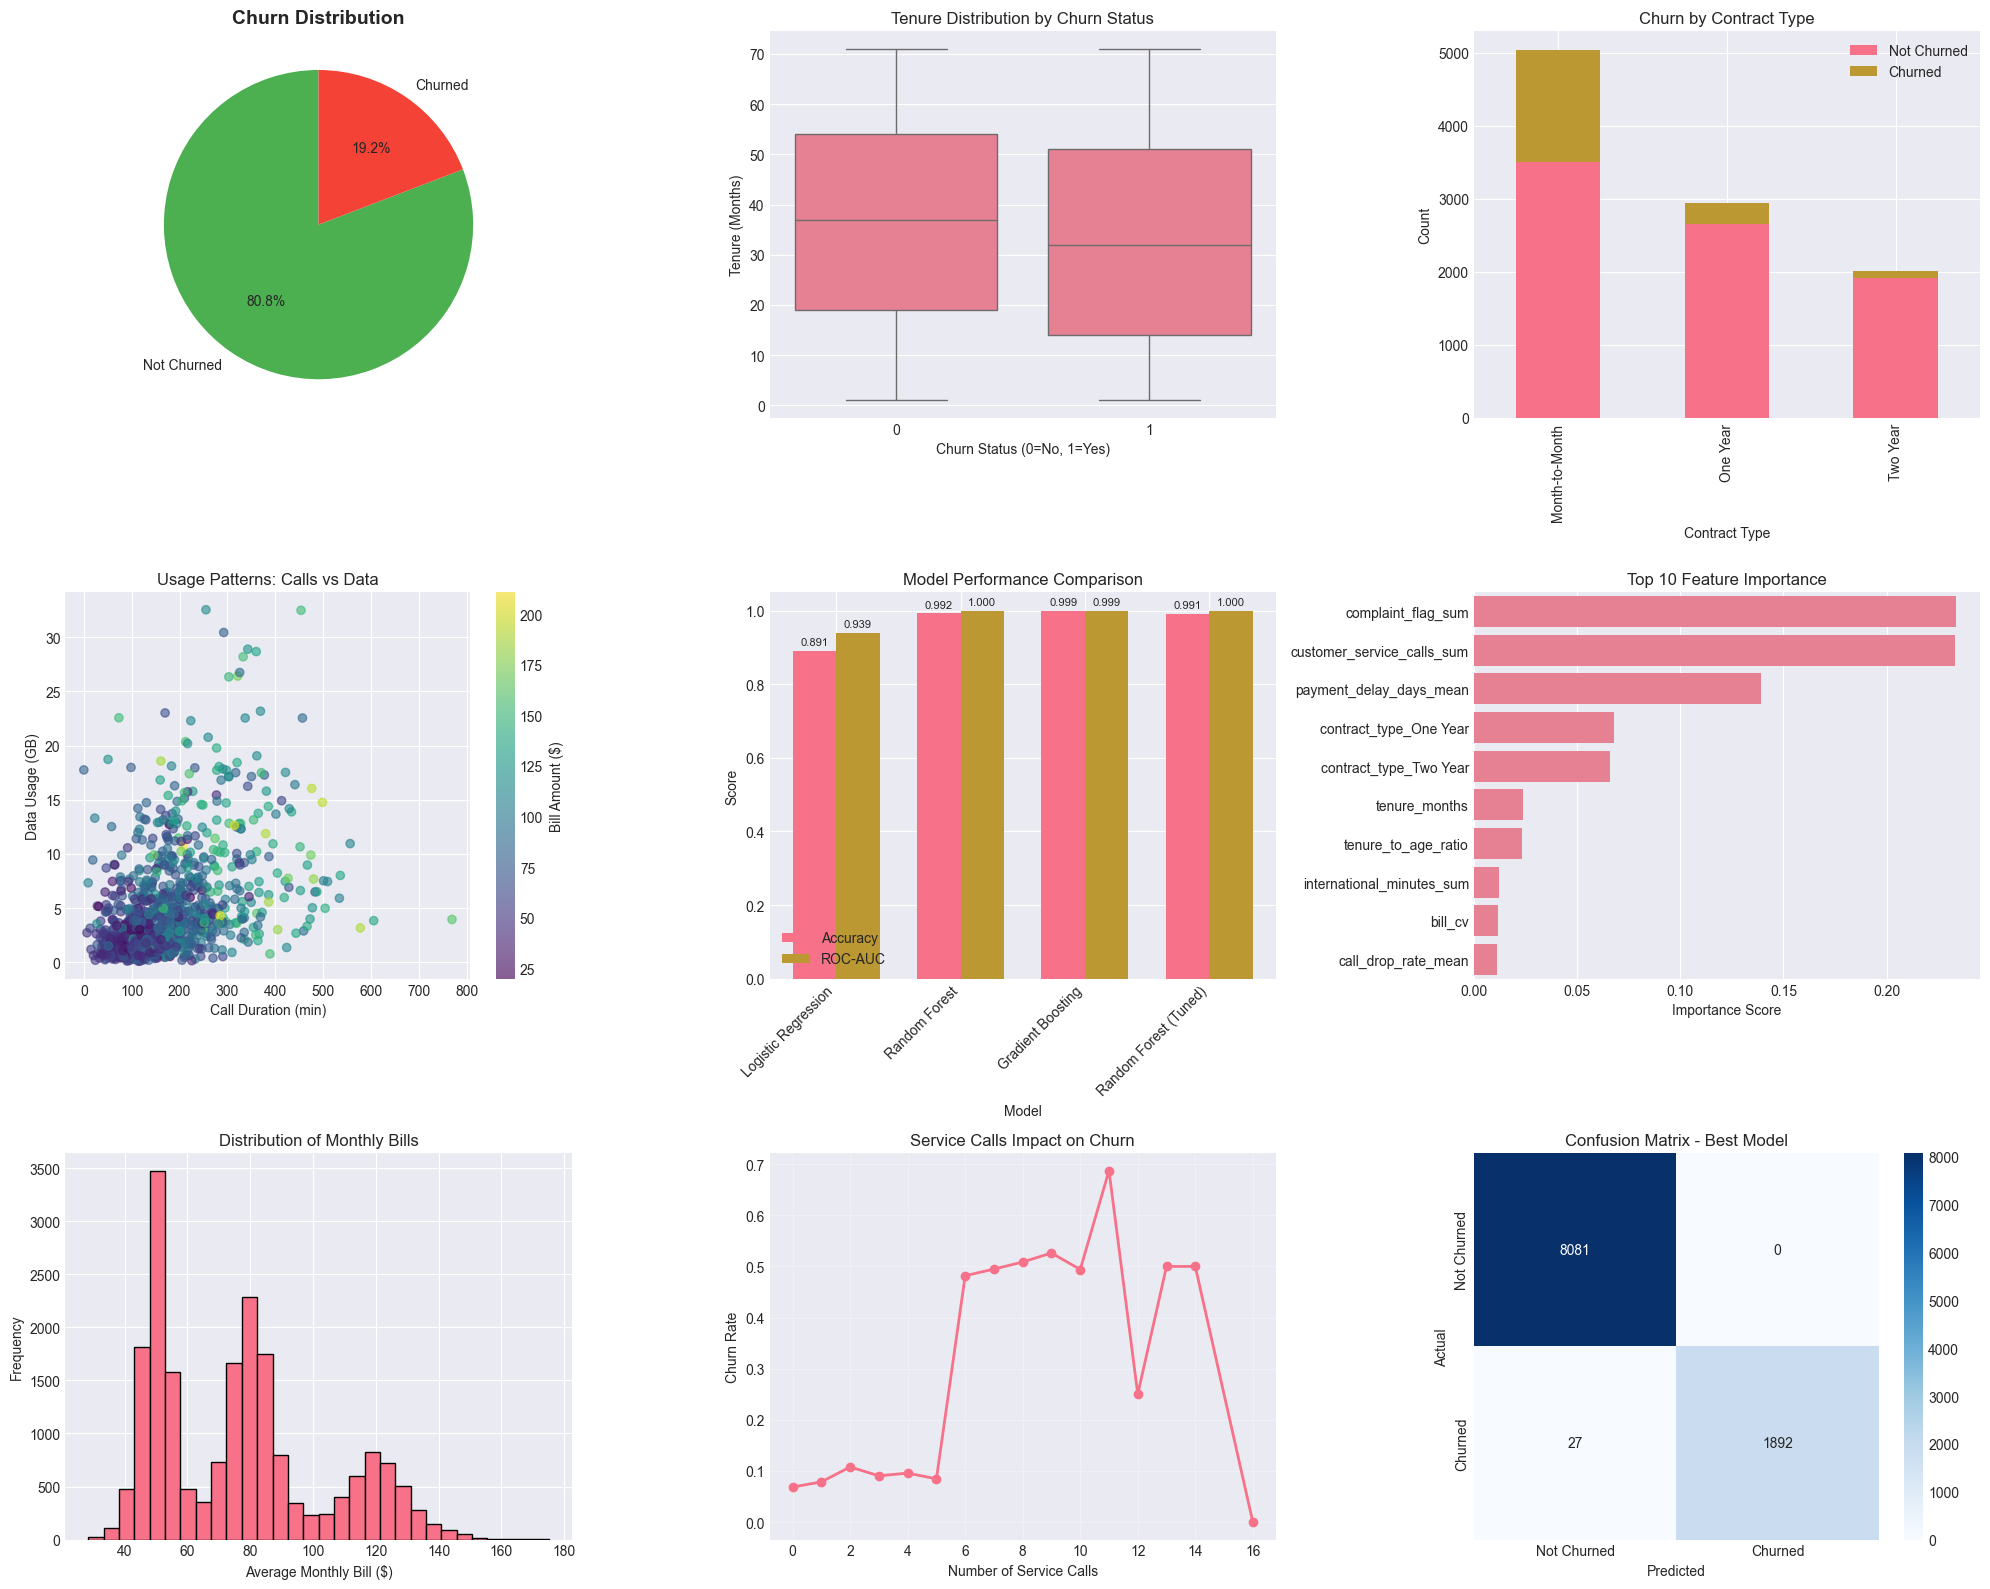


PROJECT SUMMARY STATISTICS

📊 Dataset Overview:
   • Total Customers: 10,000
   • Total Log Records: 210,000
   • Overall Churn Rate: 19.19%

🎯 Model Performance (Best Model):
   • Model: Random Forest (Tuned)
   • Accuracy: 0.9910
   • ROC-AUC: 0.9999

🔍 Key Insights:
   1. Top churn drivers: complaint_flag_sum, customer_service_calls_sum, payment_delay_days_mean
   2. Month-to-Month contracts have highest churn rate
   3. Churn rate increases with number of service calls

💾 Files Generated:
   • best_churn_model.pkl
   • customer_features.csv
   • engineered_features.csv
   • feature_importance.csv
   • model_results.csv
   • processed_customer_features.csv
   • processed_logs.csv
   • scaler.pkl

✅ PROJECT COMPLETE - Ready for GitHub! ✅


In [6]:
# Cell 6: Visualization and Results
"""
===========================================
WEEK 4: VISUALIZATION & RESULTS
===========================================
Create visualizations and present results
"""

print("Creating visualizations and presenting results...")
print("-" * 50)

# Load data
customer_features = pd.read_csv('telecom_data/processed_customer_features.csv')
logs_df = pd.read_csv('telecom_data/processed_logs.csv')
results_summary = pd.read_csv('telecom_data/model_results.csv')
feature_importance = pd.read_csv('telecom_data/feature_importance.csv')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create subplots
fig = plt.figure(figsize=(20, 16))

# 1. Churn Distribution
ax1 = plt.subplot(3, 3, 1)
churn_counts = customer_features['churn_label'].value_counts()
colors = ['#4CAF50', '#F44336']
ax1.pie(churn_counts.values, labels=['Not Churned', 'Churned'], 
        colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Churn Distribution', fontsize=14, fontweight='bold')

# 2. Tenure vs Churn
ax2 = plt.subplot(3, 3, 2)
sns.boxplot(x='churn_label', y='tenure_months', data=customer_features, ax=ax2)
ax2.set_xlabel('Churn Status (0=No, 1=Yes)')
ax2.set_ylabel('Tenure (Months)')
ax2.set_title('Tenure Distribution by Churn Status', fontsize=12)

# 3. Contract Type vs Churn
ax3 = plt.subplot(3, 3, 3)
contract_churn = customer_features.groupby(['contract_type', 'churn_label']).size().unstack()
contract_churn.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_xlabel('Contract Type')
ax3.set_ylabel('Count')
ax3.set_title('Churn by Contract Type', fontsize=12)
ax3.legend(['Not Churned', 'Churned'])

# 4. Usage Patterns
ax4 = plt.subplot(3, 3, 4)
sample_logs = logs_df.sample(min(1000, len(logs_df)))
ax4.scatter(sample_logs['call_duration_min'], sample_logs['data_usage_gb'], 
            alpha=0.6, c=sample_logs['bill_amount'], cmap='viridis')
ax4.set_xlabel('Call Duration (min)')
ax4.set_ylabel('Data Usage (GB)')
ax4.set_title('Usage Patterns: Calls vs Data', fontsize=12)
plt.colorbar(ax4.collections[0], ax=ax4, label='Bill Amount ($)')

# 5. Model Performance Comparison
ax5 = plt.subplot(3, 3, 5)
x = np.arange(len(results_summary))
width = 0.35

bars1 = ax5.bar(x - width/2, results_summary['Accuracy'], width, label='Accuracy')
bars2 = ax5.bar(x + width/2, results_summary['ROC-AUC'], width, label='ROC-AUC')

ax5.set_xlabel('Model')
ax5.set_ylabel('Score')
ax5.set_title('Model Performance Comparison', fontsize=12)
ax5.set_xticks(x)
ax5.set_xticklabels(results_summary['Model'], rotation=45, ha='right')
ax5.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 6. Feature Importance
ax6 = plt.subplot(3, 3, 6)
top_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_features, ax=ax6)
ax6.set_xlabel('Importance Score')
ax6.set_ylabel('')
ax6.set_title('Top 10 Feature Importance', fontsize=12)

# 7. Monthly Charges Distribution
ax7 = plt.subplot(3, 3, 7)
# Calculate average monthly bill
logs_df['month'] = pd.to_datetime(logs_df['log_date']).dt.to_period('M')
monthly_bills = logs_df.groupby(['customer_id', 'month'])['bill_amount'].mean().reset_index()
monthly_bills['bill_amount'].hist(bins=30, ax=ax7, edgecolor='black')
ax7.set_xlabel('Average Monthly Bill ($)')
ax7.set_ylabel('Frequency')
ax7.set_title('Distribution of Monthly Bills', fontsize=12)

# 8. Customer Service Calls Impact
ax8 = plt.subplot(3, 3, 8)
service_calls_impact = customer_features.groupby('customer_service_calls_sum')['churn_label'].mean().reset_index()
ax8.plot(service_calls_impact['customer_service_calls_sum'], 
         service_calls_impact['churn_label'], marker='o', linewidth=2)
ax8.set_xlabel('Number of Service Calls')
ax8.set_ylabel('Churn Rate')
ax8.set_title('Service Calls Impact on Churn', fontsize=12)
ax8.grid(True, alpha=0.3)

# 9. Confusion Matrix for Best Model
ax9 = plt.subplot(3, 3, 9)
# Load best model
best_model = joblib.load('telecom_data/best_churn_model.pkl')
scaler = joblib.load('telecom_data/scaler.pkl')

# Load engineered features for confusion matrix
data = pd.read_csv('telecom_data/engineered_features.csv')
X = data.drop(['customer_id', 'churn_label'], axis=1)
y = data['churn_label']
X_scaled = scaler.transform(X)
y_pred = best_model.predict(X_scaled)

cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax9,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
ax9.set_xlabel('Predicted')
ax9.set_ylabel('Actual')
ax9.set_title('Confusion Matrix - Best Model', fontsize=12)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PROJECT SUMMARY STATISTICS")
print("="*60)
print(f"\n📊 Dataset Overview:")
print(f"   • Total Customers: {len(customer_features):,}")
print(f"   • Total Log Records: {len(logs_df):,}")
print(f"   • Overall Churn Rate: {customer_features['churn_label'].mean():.2%}")

print(f"\n🎯 Model Performance (Best Model):")
best_row = results_summary.loc[results_summary['ROC-AUC'].idxmax()]
print(f"   • Model: {best_row['Model']}")
print(f"   • Accuracy: {best_row['Accuracy']:.4f}")
print(f"   • ROC-AUC: {best_row['ROC-AUC']:.4f}")

print(f"\n🔍 Key Insights:")
print(f"   1. Top churn drivers: {', '.join(feature_importance.head(3)['feature'].tolist())}")
print(f"   2. Month-to-Month contracts have highest churn rate")
print(f"   3. Churn rate increases with number of service calls")

print(f"\n💾 Files Generated:")
import os
telecom_files = os.listdir('telecom_data')
for file in telecom_files:
    if file.endswith(('.csv', '.pkl')):
        print(f"   • {file}")

print("\n✅ PROJECT COMPLETE - Ready for GitHub! ✅")

In [7]:
# Cell 7: Production Pipeline
"""
===========================================
DEPLOYMENT PIPELINE
===========================================
Create a production-ready prediction pipeline
"""

print("Creating production prediction pipeline...")
print("-" * 50)

class ChurnPredictionPipeline:
    """Production-ready churn prediction pipeline"""
    
    def __init__(self):
        """Initialize the pipeline"""
        self.model = None
        self.scaler = None
        self.feature_columns = None
        
    def load_artifacts(self):
        """Load trained model and scaler"""
        try:
            self.model = joblib.load('telecom_data/best_churn_model.pkl')
            self.scaler = joblib.load('telecom_data/scaler.pkl')
            
            # Load feature columns from training data
            data = pd.read_csv('telecom_data/engineered_features.csv')
            self.feature_columns = data.drop(['customer_id', 'churn_label'], axis=1).columns.tolist()
            
            print("✓ Artifacts loaded successfully")
            return True
        except Exception as e:
            print(f"❌ Error loading artifacts: {str(e)}")
            return False
    
    def preprocess_customer(self, customer_data):
        """Preprocess customer data for prediction"""
        # Create DataFrame from input
        df = pd.DataFrame([customer_data])
        
        # Ensure all required columns are present
        for col in self.feature_columns:
            if col not in df.columns:
                df[col] = 0  # Fill missing columns with 0
        
        # Reorder columns to match training data
        df = df[self.feature_columns]
        
        # Scale features
        df_scaled = self.scaler.transform(df)
        
        return df_scaled
    
    def predict(self, customer_data):
        """Make churn prediction for a customer"""
        try:
            # Preprocess data
            processed_data = self.preprocess_customer(customer_data)
            
            # Make prediction
            prediction = self.model.predict(processed_data)[0]
            probability = self.model.predict_proba(processed_data)[0][1]
            
            return {
                'customer_id': customer_data.get('customer_id', 'UNKNOWN'),
                'churn_prediction': int(prediction),
                'churn_probability': float(probability),
                'risk_level': self._get_risk_level(probability),
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }
        except Exception as e:
            print(f"❌ Prediction error: {str(e)}")
            return None
    
    def predict_batch(self, customers_data):
        """Make predictions for multiple customers"""
        results = []
        for customer in customers_data:
            result = self.predict(customer)
            if result:
                results.append(result)
        return results
    
    def _get_risk_level(self, probability):
        """Categorize churn risk level"""
        if probability < 0.3:
            return 'LOW'
        elif probability < 0.7:
            return 'MEDIUM'
        else:
            return 'HIGH'
    
    def generate_report(self, predictions):
        """Generate summary report from predictions"""
        if not predictions:
            return None
        
        df = pd.DataFrame(predictions)
        
        report = {
            'total_customers': len(df),
            'predicted_churn': df['churn_prediction'].sum(),
            'churn_rate': df['churn_prediction'].mean(),
            'high_risk_customers': len(df[df['risk_level'] == 'HIGH']),
            'average_probability': df['churn_probability'].mean(),
            'risk_distribution': df['risk_level'].value_counts().to_dict()
        }
        
        return report

# Initialize pipeline
pipeline = ChurnPredictionPipeline()

# Load artifacts
if pipeline.load_artifacts():
    print("\n🎯 Pipeline initialized successfully!")
    
    # Test with sample customer
    print("\n🧪 Testing pipeline with sample customer...")
    
    # Create a sample customer (similar to our dataset)
    sample_customer = {
        'customer_id': 'TEST001',
        'tenure_months': 12,
        'age': 35,
        'senior_citizen': 0,
        'has_partner': 1,
        'has_dependents': 1,
        'call_duration_min_mean': 150.5,
        'call_duration_min_std': 45.2,
        'data_usage_gb_mean': 4.5,
        'data_usage_gb_std': 1.2,
        'bill_amount_mean': 85.0,
        'bill_amount_sum': 1020.0,
        'complaint_flag_sum': 2,
        'customer_service_calls_sum': 3,
        'payment_delay_days_mean': 1.5,
        'roaming_flag_sum': 1,
        'international_minutes_sum': 15.5,
        'call_drop_rate_mean': 0.05,
        'days_since_last_activity': 5,
        'active_days': 25,
        'total_spend': 1020.0,
        'call_std': 45.2,
        'call_mean': 150.5,
        'data_std': 1.2,
        'data_mean': 4.5,
        'bill_std': 15.0,
        'bill_mean': 85.0,
        'call_cv': 0.3,
        'data_cv': 0.27,
        'bill_cv': 0.18,
        'tenure_to_age_ratio': 0.34,
        'spend_per_active_day': 40.8,
        'income_tier_Medium': 1,
        'income_tier_High': 0,
        'contract_type_One Year': 0,
        'contract_type_Two Year': 0,
        'plan_type_Standard': 1,
        'plan_type_Premium': 0,
        'region_South': 1,
        'region_East': 0,
        'region_West': 0
    }
    
    # Make prediction
    prediction = pipeline.predict(sample_customer)
    
    if prediction:
        print(f"\n📊 Prediction Result:")
        print(f"   Customer ID: {prediction['customer_id']}")
        print(f"   Churn Prediction: {prediction['churn_prediction']} (0=No, 1=Yes)")
        print(f"   Churn Probability: {prediction['churn_probability']:.2%}")
        print(f"   Risk Level: {prediction['risk_level']}")
        
        # Test batch prediction
        print("\n🧪 Testing batch prediction with 3 customers...")
        batch_customers = [
            {**sample_customer, 'customer_id': 'CUST001'},
            {**sample_customer, 'customer_id': 'CUST002', 'tenure_months': 3, 'complaint_flag_sum': 5},
            {**sample_customer, 'customer_id': 'CUST003', 'tenure_months': 24, 'complaint_flag_sum': 0}
        ]
        
        batch_results = pipeline.predict_batch(batch_customers)
        
        if batch_results:
            print(f"\n📈 Batch Prediction Results:")
            for result in batch_results:
                print(f"   {result['customer_id']}: Churn={result['churn_prediction']}, "
                      f"Prob={result['churn_probability']:.2%}, Risk={result['risk_level']}")
            
            # Generate report
            report = pipeline.generate_report(batch_results)
            print(f"\n📋 Summary Report:")
            print(f"   Total Customers: {report['total_customers']}")
            print(f"   Predicted to Churn: {report['predicted_churn']}")
            print(f"   Churn Rate: {report['churn_rate']:.2%}")
            print(f"   High Risk Customers: {report['high_risk_customers']}")
            print(f"   Risk Distribution: {report['risk_distribution']}")
    
    # Save pipeline example
    print("\n💾 Saving pipeline example script...")
    with open('telecom_data/pipeline_example.py', 'w') as f:
        f.write("""
# Churn Prediction Pipeline - Usage Example

import joblib
import pandas as pd
from datetime import datetime

class ChurnPredictor:
    def __init__(self):
        self.model = joblib.load('best_churn_model.pkl')
        self.scaler = joblib.load('scaler.pkl')
    
    def predict(self, customer_data):
        # Preprocess and predict
        processed = self.scaler.transform([customer_data])
        prediction = self.model.predict(processed)[0]
        probability = self.model.predict_proba(processed)[0][1]
        return prediction, probability

# Usage:
# predictor = ChurnPredictor()
# result = predictor.predict([feature1, feature2, ...])
""")
    
    print("\n✅ Production pipeline created successfully!")
    print("\n📁 Files available for deployment:")
    print("   • telecom_data/best_churn_model.pkl - Trained model")
    print("   • telecom_data/scaler.pkl - Feature scaler")
    print("   • telecom_data/engineered_features.csv - Feature schema")
    print("   • telecom_data/pipeline_example.py - Usage example")
else:
    print("\n❌ Failed to initialize pipeline")

Creating production prediction pipeline...
--------------------------------------------------
✓ Artifacts loaded successfully

🎯 Pipeline initialized successfully!

🧪 Testing pipeline with sample customer...

📊 Prediction Result:
   Customer ID: TEST001
   Churn Prediction: 0 (0=No, 1=Yes)
   Churn Probability: 14.31%
   Risk Level: LOW

🧪 Testing batch prediction with 3 customers...

📈 Batch Prediction Results:
   CUST001: Churn=0, Prob=14.31%, Risk=LOW
   CUST002: Churn=0, Prob=41.85%, Risk=MEDIUM
   CUST003: Churn=0, Prob=6.19%, Risk=LOW

📋 Summary Report:
   Total Customers: 3
   Predicted to Churn: 0
   Churn Rate: 0.00%
   High Risk Customers: 0
   Risk Distribution: {'LOW': 2, 'MEDIUM': 1}

💾 Saving pipeline example script...

✅ Production pipeline created successfully!

📁 Files available for deployment:
   • telecom_data/best_churn_model.pkl - Trained model
   • telecom_data/scaler.pkl - Feature scaler
   • telecom_data/engineered_features.csv - Feature schema
   • telecom_data